In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [3]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle

from data_loading import get_movielens_data
from evaluation import evaluate_policy
from policies.bcmab_rp import BCMAB_RP
from policies.cbrap import CBRAP
from policies.linucb import LinUCB
from policies.linear_ts import LinearTS
from policies.d_lin_ts import DLinTS
from policies.random import RandomPolicy
from policies.egreedy import EGreedy
from policies.deepfm import DeepFM_OnlinePolicy
from reduct_matrix import get_reduct_matrix

from sklearn.model_selection import train_test_split

In [4]:
# Reproducibility
seed = 42
np.random.seed(seed)

In [5]:
times = 50000

DeepCTR-PyTorch version 0.2.9 detected. Your version is 0.2.2.
Use `pip install -U deepctr-torch` to upgrade.Changelog: https://github.com/shenweichen/DeepCTR-Torch/releases/tag/v0.2.9


In [6]:
dataset = get_movielens_data(times, tune=False)

Dataset creation took 11.207427024841309 s.


### Define policies

In [7]:
total_start_ts = time.time()

#### Introduce nonstationarity

In [8]:
CHANGE_POINTS = [1, 5000, 10000, 20000, 35000, 50000, 65000, 80000, 90000, 100000]

In [9]:
intervals = list(zip(CHANGE_POINTS, CHANGE_POINTS[1:]))
intervals

[(1, 5000),
 (5000, 10000),
 (10000, 20000),
 (20000, 35000),
 (35000, 50000),
 (50000, 65000),
 (65000, 80000),
 (80000, 90000),
 (90000, 100000)]

In [10]:
SHIFT_SIZE = 0.33

In [11]:


def evaluation_nonstationarity_function(trial, arm, num_of_arms):
    """Takes trial and arm index as input and returns index of arm with which to swap."""
    N_ARMS = num_of_arms
    shift_size_int = int(SHIFT_SIZE * N_ARMS)

    # intervals = [1, 5000, 10000, 20000, 35000, 50000, 65000, 80000, 100000]
    intervals = CHANGE_POINTS
    for i, (start, end) in enumerate(zip(intervals, intervals[1:])):
        if start <= trial < end:
            return (arm + i * shift_size_int) % N_ARMS
    return arm



#### Check nonstationarity

In [13]:
reward_vecs = np.zeros((times, 1000))
users = dataset.generate_users(times, tune=False)

for i, user_data in enumerate(users):
    context, reward_vector, score_true, missing_vector = user_data
    reward_vecs[i, :] = reward_vector

First user in exp from 2008-10-29 03:36:53
Last user in exp from 2009-01-05 05:52:22


In [14]:
nonst_reward_vecs = np.zeros(reward_vecs.shape)
for t in range(reward_vecs.shape[0]):
    for a in range(reward_vecs.shape[1]):
        nonst_reward_vecs[t, a] = reward_vecs[t, evaluation_nonstationarity_function(t, a, 1000)]

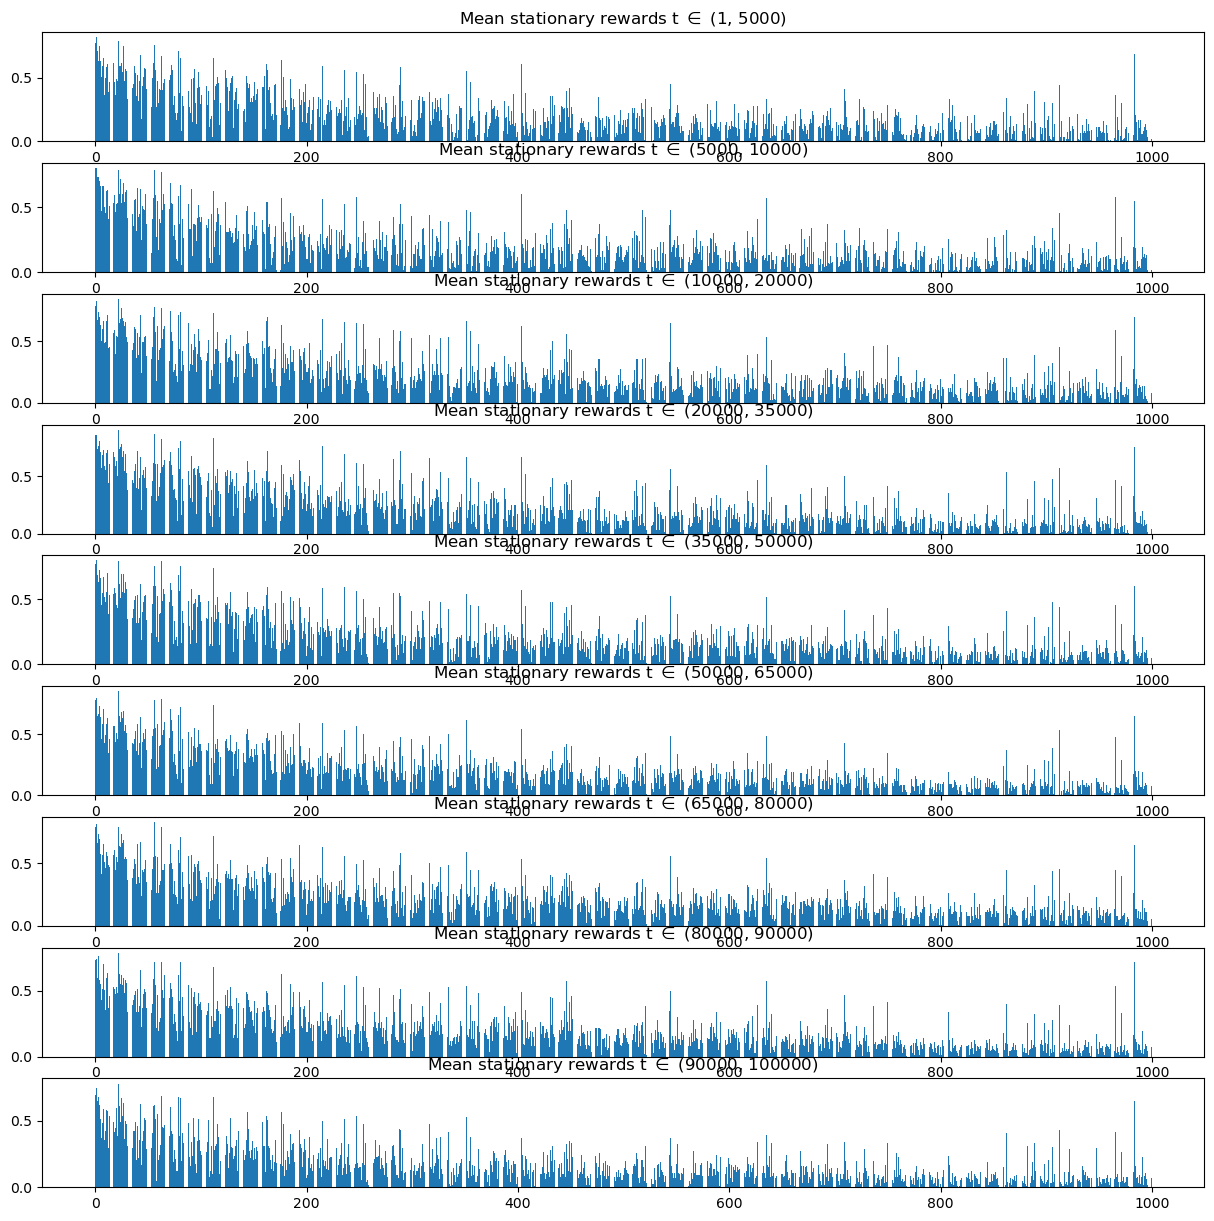

In [15]:
fig, axs = plt.subplots(len(intervals) ,1, figsize=(15, 15))

for i, intrvl in enumerate(intervals):
    intrvl_mean_rews = reward_vecs[intrvl[0]:intrvl[1]].mean(axis=0)
    axs[i].bar(list(range(len(dataset.actions))), intrvl_mean_rews)
    axs[i].set_title(fr"Mean stationary rewards t $\in$ {intrvl}")

plt.show()

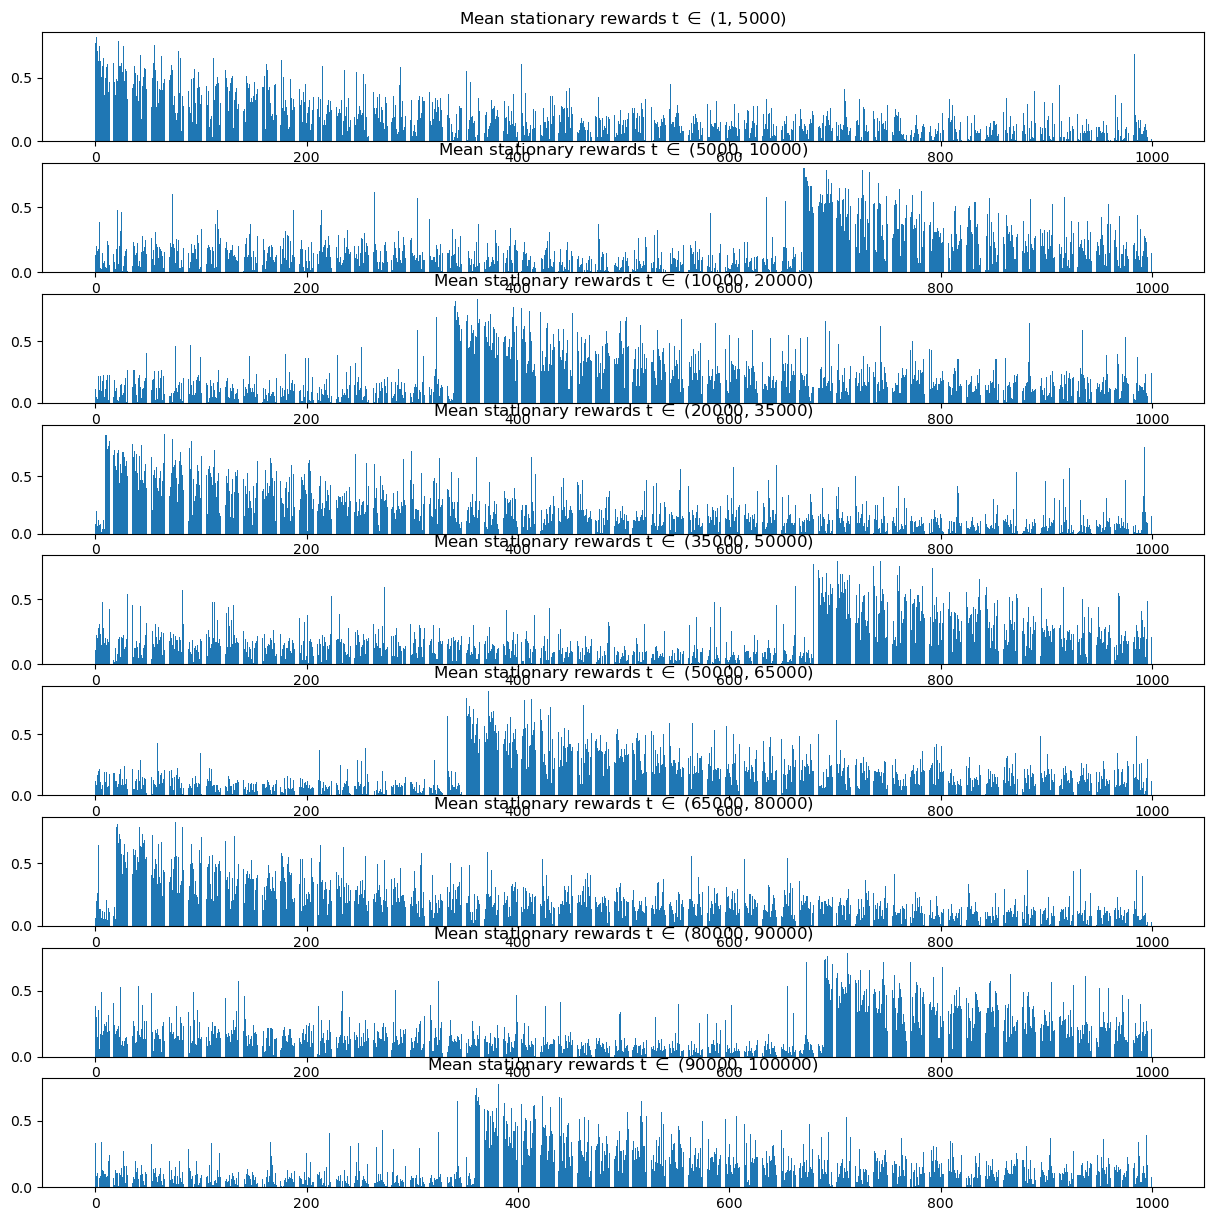

In [16]:
fig, axs = plt.subplots(len(intervals) ,1, figsize=(15, 15))

for i, intrvl in enumerate(intervals):
    intrvl_mean_rews = nonst_reward_vecs[intrvl[0]:intrvl[1]].mean(axis=0)
    axs[i].bar(list(range(len(dataset.actions))), intrvl_mean_rews)
    axs[i].set_title(fr"Mean stationary rewards t $\in$ {intrvl}")

plt.show()


In [17]:
del nonst_reward_vecs

### Run evaluation

#### Define policies

In [14]:
ctx_dim = 120


policies = {
    # Tuned
#     'LinearTS': LinearTS(context_dimension=ctx_dim, nu=0.3, seed=seed),
#     'LinUCB': LinUCB(context_dimension=ctx_dim, alpha=0.9),
#     'EGreedy': EGreedy(epsilon=0.001),
#     'DLinTS': DLinTS(context_dimension=ctx_dim, gamma=0.999, a=0.2,  seed=seed),
#     'CBRAP d=6': CBRAP(context_dimension=ctx_dim, red_dim=6, alpha=0.3),
#     'CBRAP d=12': CBRAP(context_dimension=ctx_dim, red_dim=12, alpha=0.7),
#     'CBRAP d=24': CBRAP(context_dimension=ctx_dim, red_dim=24, alpha=0.5),
#     'CBRAP d=60': CBRAP(context_dimension=ctx_dim, red_dim=60, alpha=0.4),
#     'CBRAP d=120': CBRAP(context_dimension=ctx_dim, red_dim=120, alpha=0.6),
#     'BCMAB-RP d=6': BCMAB_RP(context_dimension=ctx_dim, red_dim=6, gamma=0.9, a=0.1, seed=seed),
#     'BCMAB-RP d=12': BCMAB_RP(context_dimension=ctx_dim, red_dim=12, gamma=0.99, a=0.1, seed=seed),
#     'BCMAB-RP d=24': BCMAB_RP(context_dimension=ctx_dim, red_dim=24, gamma=0.9, a=0.1, seed=seed),
#     'BCMAB-RP d=60': BCMAB_RP(context_dimension=ctx_dim, red_dim=60, gamma=0.999, a=0.2, seed=seed),
#     'BCMAB-RP d=120': BCMAB_RP(context_dimension=ctx_dim, red_dim=120, gamma=0.999, a=0.2, seed=seed),
    'DeepFM': DeepFM_OnlinePolicy(context_dimension=ctx_dim, batch_size=1000),
    'Random': RandomPolicy(),
}

In [15]:
results = {'reward': {}, 'ndcg': {}}
for p_name, policy in policies.items():
    start_ts = time.time()

    reward, ndcg = evaluate_policy(
        policy, times, dataset, nonstationarity_function=evaluation_nonstationarity_function
    )
    results['reward'][p_name] = reward
    results['ndcg'][p_name] = ndcg
    print(f"Total reward of {p_name} is {reward[-1][0]}")
    print(f"Total time of {p_name} is {datetime.timedelta(seconds=time.time() - start_ts)}")

Using evaluation dataset
First user in exp from 2008-11-25 22:37:03
Last user in exp from 2009-01-05 05:52:22
0
cpu
Train on 1001 samples, validate on 0 samples, 4 steps per epoch
Epoch 1/10
0s - loss:  0.6344
Epoch 2/10
0s - loss:  0.5957
Epoch 3/10
0s - loss:  0.5934
Epoch 4/10
0s - loss:  0.5893
Epoch 5/10
0s - loss:  0.5871
Epoch 6/10
0s - loss:  0.5801
Epoch 7/10
0s - loss:  0.5729
Epoch 8/10
0s - loss:  0.5887
Epoch 9/10
0s - loss:  0.5746
Epoch 10/10
0s - loss:  0.5667
cpu
Train on 2001 samples, validate on 0 samples, 8 steps per epoch
Epoch 1/10
0s - loss:  0.5598
Epoch 2/10
0s - loss:  0.5475
Epoch 3/10
0s - loss:  0.5401
Epoch 4/10
0s - loss:  0.5379
Epoch 5/10
0s - loss:  0.5329
Epoch 6/10
0s - loss:  0.5214
Epoch 7/10
0s - loss:  0.5296
Epoch 8/10
0s - loss:  0.5126
Epoch 9/10
0s - loss:  0.5137
Epoch 10/10
0s - loss:  0.5234
cpu
Train on 3001 samples, validate on 0 samples, 12 steps per epoch
Epoch 1/10
0s - loss:  0.5560
Epoch 2/10
0s - loss:  0.5542
Epoch 3/10
0s - loss:

Epoch 8/10
0s - loss:  0.0881
Epoch 9/10
0s - loss:  0.0867
Epoch 10/10
0s - loss:  0.0857
cpu
Train on 23001 samples, validate on 0 samples, 90 steps per epoch
Epoch 1/10
0s - loss:  0.1062
Epoch 2/10
0s - loss:  0.1006
Epoch 3/10
0s - loss:  0.0967
Epoch 4/10
0s - loss:  0.0953
Epoch 5/10
0s - loss:  0.0936
Epoch 6/10
0s - loss:  0.0922
Epoch 7/10
0s - loss:  0.0914
Epoch 8/10
0s - loss:  0.0898
Epoch 9/10
0s - loss:  0.0890
Epoch 10/10
0s - loss:  0.0880
cpu
Train on 24001 samples, validate on 0 samples, 94 steps per epoch
Epoch 1/10
0s - loss:  0.1190
Epoch 2/10
0s - loss:  0.1100
Epoch 3/10
0s - loss:  0.1071
Epoch 4/10
0s - loss:  0.1044
Epoch 5/10
0s - loss:  0.1028
Epoch 6/10
0s - loss:  0.1007
Epoch 7/10
0s - loss:  0.0989
Epoch 8/10
0s - loss:  0.0978
Epoch 9/10
0s - loss:  0.0967
Epoch 10/10
0s - loss:  0.0963
cpu
Train on 25001 samples, validate on 0 samples, 98 steps per epoch
Epoch 1/10
0s - loss:  0.1023
Epoch 2/10
0s - loss:  0.0980
Epoch 3/10
0s - loss:  0.0957
Epoch 4

Epoch 8/10
0s - loss:  0.0672
Epoch 9/10
0s - loss:  0.0664
Epoch 10/10
0s - loss:  0.0660
cpu
Train on 45001 samples, validate on 0 samples, 176 steps per epoch
Epoch 1/10
0s - loss:  0.0855
Epoch 2/10
0s - loss:  0.0799
Epoch 3/10
0s - loss:  0.0776
Epoch 4/10
0s - loss:  0.0756
Epoch 5/10
0s - loss:  0.0742
Epoch 6/10
0s - loss:  0.0730
Epoch 7/10
0s - loss:  0.0722
Epoch 8/10
0s - loss:  0.0712
Epoch 9/10
0s - loss:  0.0701
Epoch 10/10
0s - loss:  0.0696
45000
cpu
Train on 46001 samples, validate on 0 samples, 180 steps per epoch
Epoch 1/10
0s - loss:  0.0822
Epoch 2/10
0s - loss:  0.0710
Epoch 3/10
0s - loss:  0.0687
Epoch 4/10
0s - loss:  0.0679
Epoch 5/10
0s - loss:  0.0668
Epoch 6/10
0s - loss:  0.0659
Epoch 7/10
0s - loss:  0.0654
Epoch 8/10
0s - loss:  0.0650
Epoch 9/10
0s - loss:  0.0646
Epoch 10/10
0s - loss:  0.0637
cpu
Train on 47001 samples, validate on 0 samples, 184 steps per epoch
Epoch 1/10
0s - loss:  0.0922
Epoch 2/10
0s - loss:  0.0780
Epoch 3/10
0s - loss:  0.073

In [16]:
with open("movielens_results.pkl", "wb") as f:
    pickle.dump(results, f)

### Plot results

In [17]:
def plot_ctrs_or_rewards(reward_dict, plot_type, change_points):
    if plot_type not in {'CTR', 'Cumulative reward'}:
        raise ValueError("plot_type should be CTR or Cumulative reward")
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    N = 10
    sorted_reward_list = sorted(
        [
            (l,r) for l, r in reward_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline = 0
    for ind, (label, reward) in enumerate(sorted_reward_list):
        times = (range(1, len(reward)+1))
        
        rewards = [r for r,t in zip(reward, times)]
        ctr = [r/t for r,t in zip(reward, times)]
        if plot_type == 'CTR':
            to_plot = ctr
            max_vline=max(max_vline, max(ctr))
        else:
            to_plot = rewards

            max_vline=max(max_vline, max(rewards))
            
        ax.plot(to_plot[N:], label=label)
        
    reward_change_points = change_points[1:-1]
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, alpha=0.65
    )    
     
    extraticks = change_points
    plt.xticks(extraticks, rotation=20)
#     plt.yticks(fontsize=25)
    
    ax.set_xlabel('Trial')
    ax.set_ylabel(f'{plot_type}')

    plt.legend();
    plt.show();

In [18]:
def plot_ndcg(cumulative_ndcg_dict):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    
    N = 10
    
    cumulative_ndcg_list = sorted(
        [
            (l,r) for l, r in cumulative_ndcg_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    for label, cumulative_ndcg in cumulative_ndcg_list:
        times = (range(1, len(cumulative_ndcg)+1))
        average_cumulative_ndcg = [cn/t for cn,t in zip(cumulative_ndcg, times)]
        ax.plot(average_cumulative_ndcg[N:], label=label)
        
    ax.set_xlabel('Trial')
    ax.set_ylabel('Average Cumulative NDCG@5')
    ax.set_title('Average Cumulative NDCG@5 on MovieLens')

    plt.legend();
    plt.show();

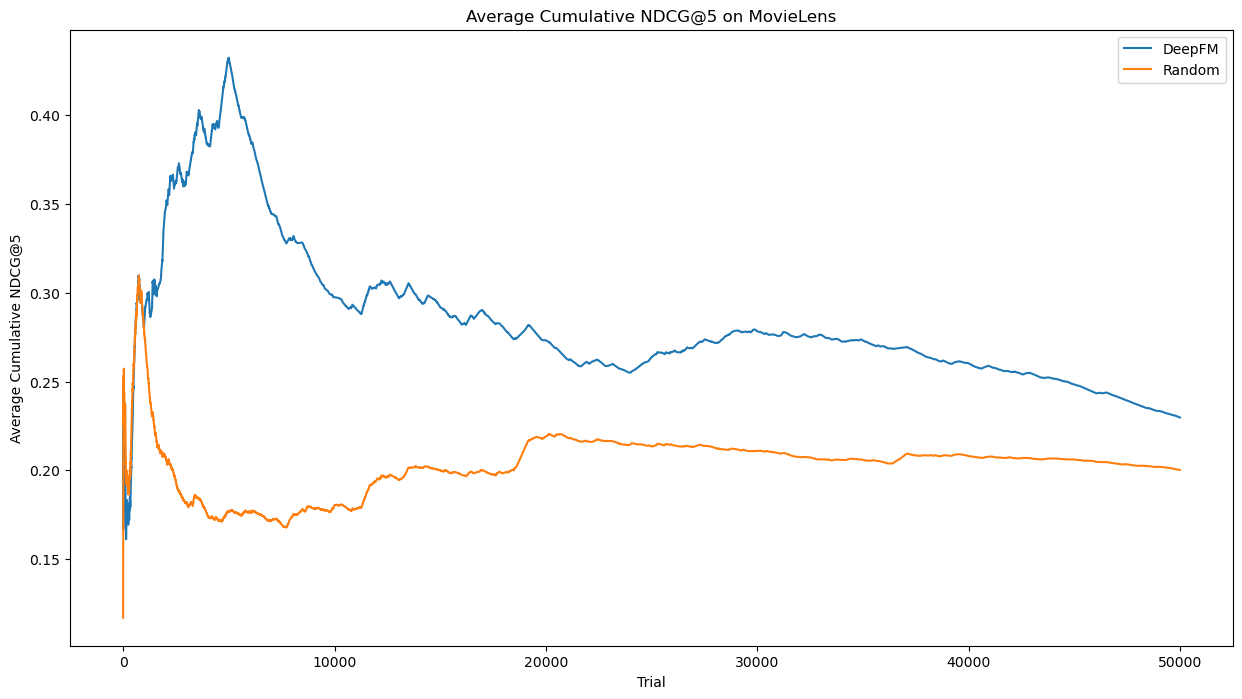

In [19]:
plot_ndcg(results['ndcg'])

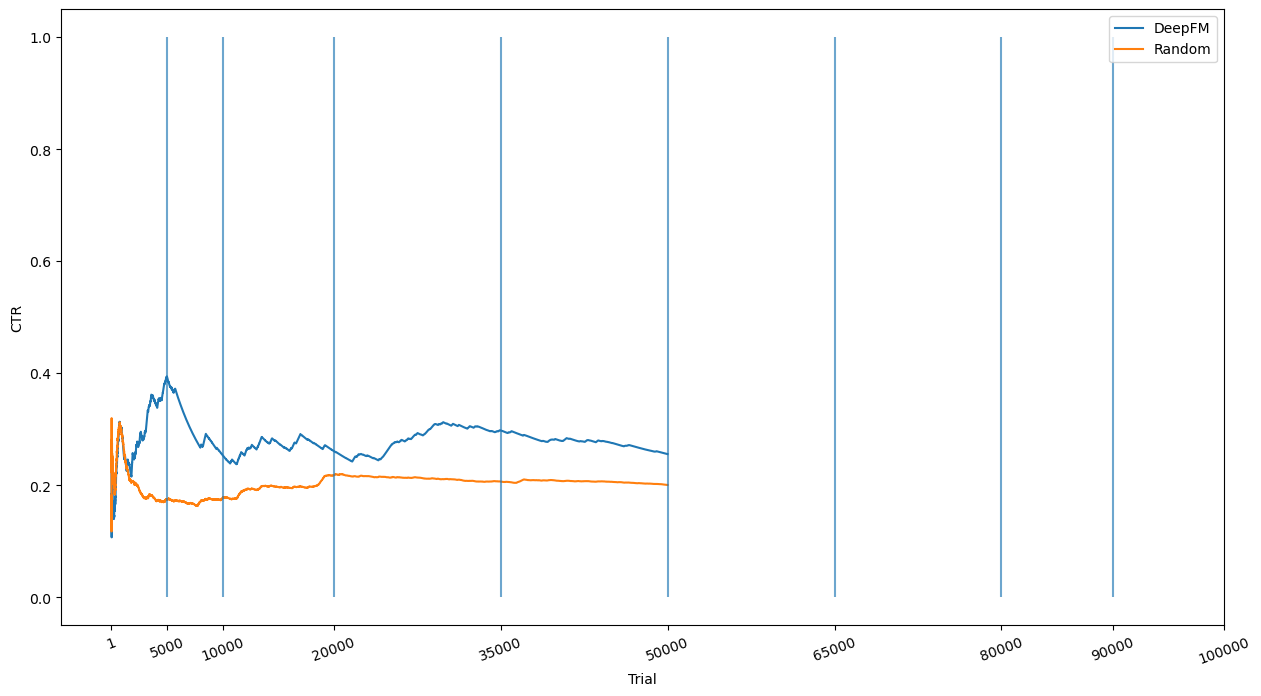

In [20]:
plot_ctrs_or_rewards(results['reward'], 'CTR', CHANGE_POINTS)

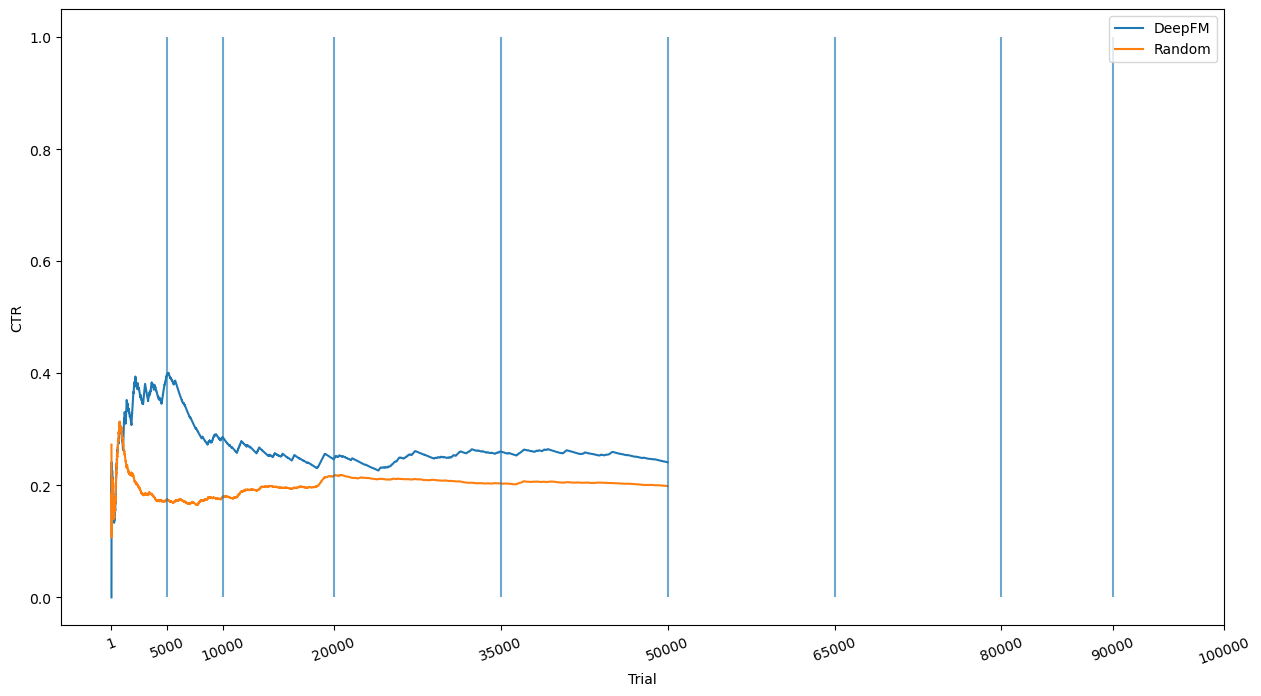

In [18]:
plot_ctrs_or_rewards(results['reward'], 'CTR', CHANGE_POINTS)

In [19]:
print(f"Total time is {datetime.timedelta(seconds=time.time() - total_start_ts)}")

Total time is 0:11:36.078429


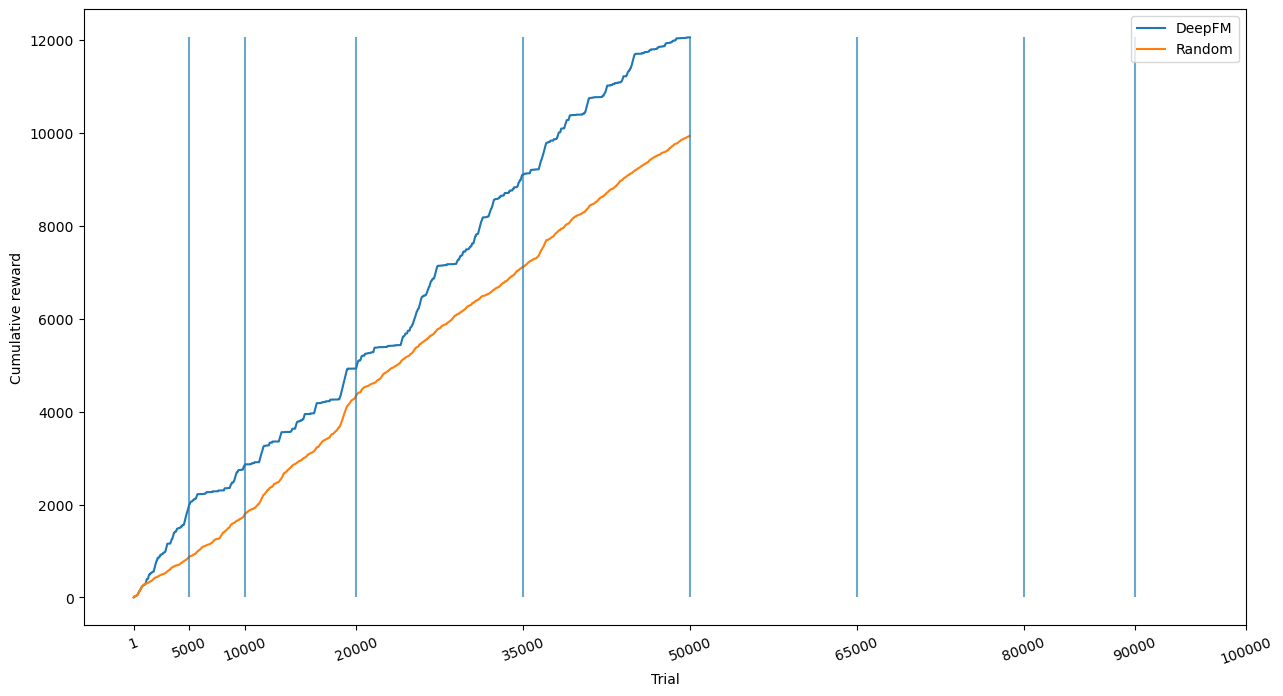

In [20]:
plot_ctrs_or_rewards(results['reward'], 'Cumulative reward', CHANGE_POINTS)

In [21]:
results['reward']['LinUCB'][-1]

KeyError: 'LinUCB'

In [ ]:
results['reward']['LinearTS'][-1]